In [1]:
# ===============================
# Library Imports
# ===============================
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from tqdm import tqdm
import copy
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset, Dataset
from functools import partial
import optuna
from typing import List, Optional, Tuple
from dataclasses import dataclass

In [2]:
# ===============================
# Global Settings for Reproducibility
# ===============================
# Choose device
device = "cpu"
torch.set_num_threads(os.cpu_count())

# Reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

In [3]:
# =======================================
# Show the MNIST images from flattened vectors
# =======================================
MNIST_LABELS = [str(i) for i in range(10)]

def plot_mnist_images(
    X: np.ndarray,
    y: np.ndarray,
    y_pred: Optional[np.ndarray] = None,
    num_images: int = 10,
    img_shape: Tuple[int, int] = (28, 28)
):
    """
    Plot MNIST images from flattened vectors

    Parameters
    ----------
    X : np.ndarray
        Flattened MNIST images (N, 784)
    y : np.ndarray
        True labels (N,) or one-hot (N, 10)
    y_pred : np.ndarray, optional
        Predicted labels (N,)
    num_images : int
        Number of images to display
    img_shape : Tuple[int, int]
        MNIST image shape (28, 28)

    Returns
    -------
    None

    Usage Example
    --------------
    plot_mnist_images(X_test, y_test, y_pred=y_pred, num_images=15)
    """
    # Convert labels to integer if needed
    if y.ndim > 1:
        y_true = np.argmax(y, axis=1)
    else:
        y_true = y

    num_images = min(num_images, len(X))

    n_cols = min(5, num_images)
    n_rows = ceil(num_images / n_cols)

    plt.figure(figsize=(3 * n_cols, 3 * n_rows))

    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i + 1)

        img = X[i].reshape(img_shape)
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        title = f"True: {MNIST_LABELS[y_true[i]]}"
        if y_pred is not None:
            title += f"\nPred: {MNIST_LABELS[y_pred[i]]}"
            color = "green" if y_true[i] == y_pred[i] else "red"
            plt.title(title, color=color, fontsize=10)
        else:
            plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

Loading MNIST dataset...
Preprocessing data...


/Users/tomcuel/.venvs/global_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Input dimension: 784, Output dimension: 10


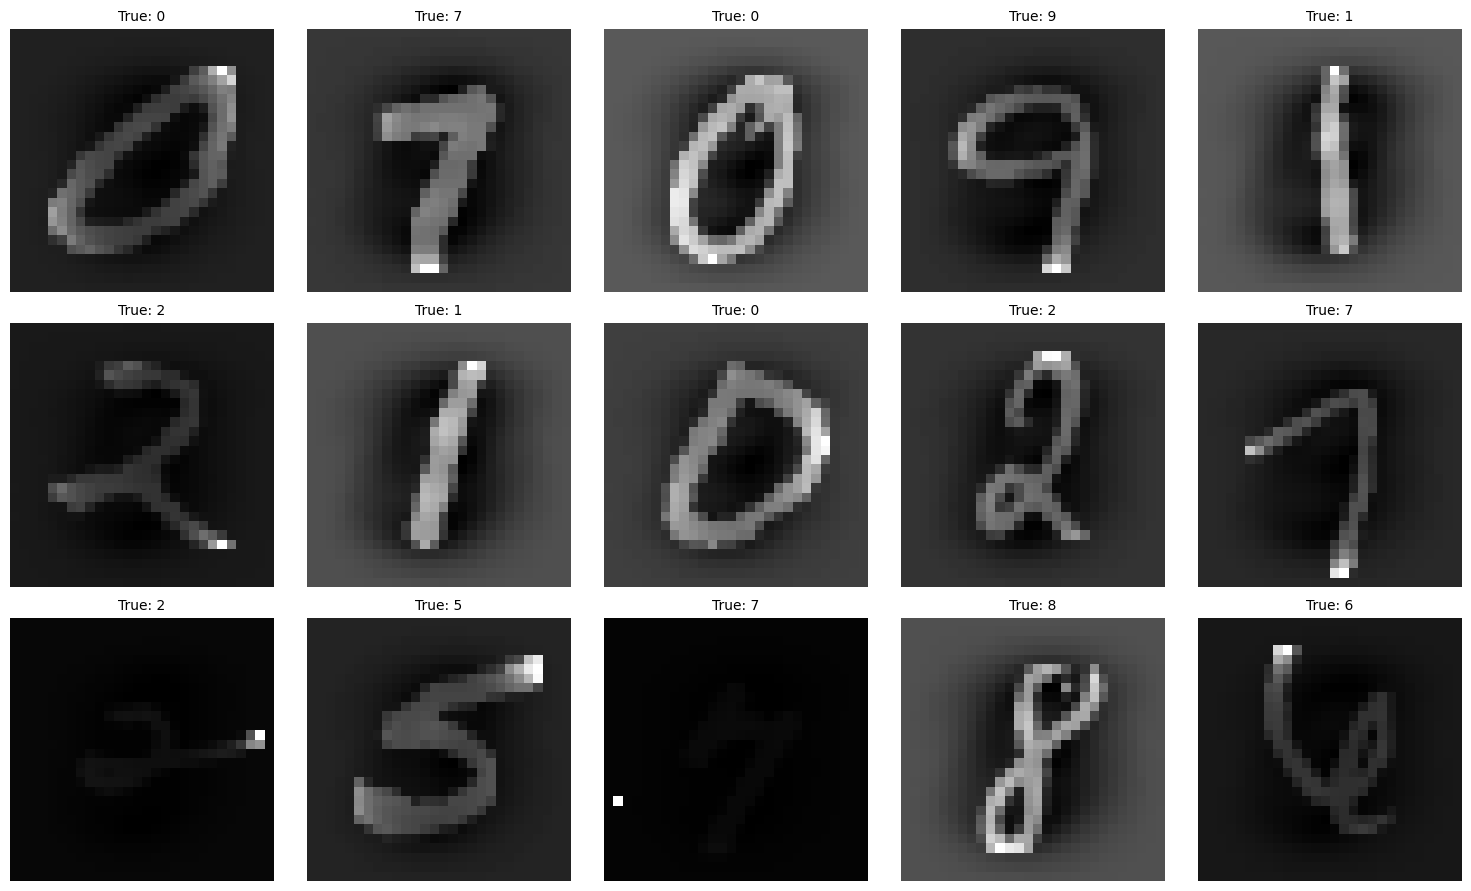

In [4]:
# =======================================
# Load and Preprocess Data of MNIST
# =======================================
print("Loading MNIST dataset...")
mnist_data = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist_data["data"]
y = mnist_data["target"]

# Normalize
print("Preprocessing data...")
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Usage:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG_SEED, stratify=y)
input_dim = int(X_train.shape[1])
output_dim = int(len(np.unique(y_train)))
print(f"Input dimension: {input_dim}, Output dimension: {output_dim}")

# Plot
plot_mnist_images(X=X_train, y=y_train, num_images=15)

In [5]:
# =======================================
# Tensor Creation
# =======================================
def df_to_tensor_dataset(
    X: np.ndarray,
    y: np.ndarray
) -> TensorDataset:
    """
    Convert numpy arrays to PyTorch TensorDataset

    Parameters
    ----------
    X : np.ndarray
        Feature data
    y : np.ndarray
        Labels

    Returns
    -------
    TensorDataset
        PyTorch TensorDataset containing features and labels

    Usage Example
    --------------
    dataset = df_to_tensor_dataset(X_train, y_train)
    """
    X_tensor = torch.tensor(X, dtype=torch.float)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X_tensor, y_tensor)

def make_dataloaders(
    dataset: Dataset,
    batch_size: int,
    shuffle: bool = False
) -> DataLoader:
    """
    Create DataLoader from Dataset
    
    Parameters
    ----------
    dataset : Dataset
        PyTorch Dataset
    batch_size : int
        Batch size for DataLoader
    shuffle : bool
        Whether to shuffle the data

    Returns
    -------
    DataLoader
        PyTorch DataLoader

    Usage Example
    --------------
    dataloader = make_dataloaders(dataset, batch_size=32, shuffle=True)
    """
    return DataLoader(dataset, 
                      batch_size=batch_size, 
                      shuffle=shuffle, 
                      num_workers=os.cpu_count(), 
                      persistent_workers=True if os.cpu_count() > 1 else False
                    )

In [6]:
# =======================================
# Activation function
# =======================================
_ACTIVATION_MAP = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "leaky_relu": lambda: nn.LeakyReLU(negative_slope=0.01),
    "gelu": nn.GELU,
    "elu": nn.ELU,
    "softmax_logit": None  # handled as logits for CrossEntropy
}

In [7]:
# =======================================
# Dataclass for hyperparameters
# =======================================
@dataclass
class TrainConfig:
    hidden_layers: list[int] = None
    activations: Optional[List[float]] = None
    dropout_rates: Optional[List[float]] = None
    loss_function: str = "cross_entropy"
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 100
    weight_decay: float = 1e-5
    step_size: int = 20
    gamma: float = 0.5

In [8]:
# =======================================
# Progressive Column
# =======================================
class ProgColumn(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        self.layers = nn.ModuleList()
        prev = input_dim
        for h in hidden_dims:
            self.layers.append(nn.Linear(prev, h))
            prev = h

    def forward(self, x):
        activations = []
        for layer in self.layers:
            x = torch.relu(layer(x))
            activations.append(x)
        return x, activations

In [9]:
# =======================================
# Progressive Network (Class-IL compatible)
# =======================================
class ProgressiveNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim

        self.columns = nn.ModuleList()
        self.heads = nn.ModuleList()
        self.lateral = nn.ModuleList()

    def add_column(self):
        col = ProgColumn(self.input_dim, self.hidden_dims)
        self.columns.append(col)

        head = nn.Linear(self.hidden_dims[-1], self.output_dim)
        self.heads.append(head)

        # Lateral connections
        if len(self.columns) > 1:
            lateral_layers = nn.ModuleList()
            for h in self.hidden_dims:
                lateral_layers.append(nn.Linear(h, h, bias=False))
            self.lateral.append(lateral_layers)

    def forward(self, x, task_id):
        activations_per_column = []

        # Forward through all columns up to task_id
        for col in self.columns[:task_id + 1]:
            _, acts = col(x)
            activations_per_column.append(acts)

        # Forward through current column again to get final hidden
        h, acts_current = self.columns[task_id](x)

        # Add lateral connections
        if task_id > 0:
            for l, lat in enumerate(self.lateral[task_id - 1]):
                for k in range(task_id):
                    h = h + lat(activations_per_column[k][l])

        return self.heads[task_id](h)

In [10]:
# =======================================
# Training Loop
# =======================================
def train_model_on_task(
    model, 
    train_dataset,
    task_id: int, 
    batch_size: int = 64,
    learning_rate: float = 0.001,
    weight_decay: float = 0.00001,
    step_size: int = 20,
    gamma: float = 0.5,
    loss_function: str = "cross_entropy",
    epochs: int = 10,
    print_every: Optional[int] = 1
):  
    # Data preparation
    train_loader = make_dataloaders(train_dataset, batch_size, shuffle=True)
    optimizer = optim.AdamW(list(model.columns[task_id].parameters()) + list(model.heads[task_id].parameters()), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = nn.CrossEntropyLoss() if loss_function == "cross_entropy" else nn.MSELoss()
    train_losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Current task loss
            outputs = model(X_batch, task_id)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)

        scheduler.step()
        avg_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)

        # Print progress
        if (epoch+1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_loss:.4f}") 

In [11]:
# =======================================
# Prediction & Evaluation
# =======================================
def predict_loader(model, loader, task_id, device=None):
    model.eval()
    if device is None:
        device = next(model.parameters()).device
    
    all_probs, all_preds, all_targets = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch, task_id)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_targets.append(y_batch.cpu())

    return (torch.cat(all_preds).numpy(), torch.cat(all_probs).numpy(), torch.cat(all_targets).numpy())

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def evaluate_task(model, dataset, task_id, device, batch_size=64):
    loader = make_dataloaders(dataset, batch_size=batch_size, shuffle=False)
    y_pred, _, y_true = predict_loader(model, loader, task_id, device)
    return accuracy_score(y_true, y_pred)

In [12]:
# =======================================
# Metrics to track performance
# =======================================
# Accuracy Matrix to track performance
class AccuracyMatrix:
    def __init__(self, num_tasks):
        self.num_tasks = num_tasks
        self.matrix = np.full((num_tasks, num_tasks), np.nan)

    def update(self, task_i, task_t, accuracy):
        """
        task_i: task evaluated
        task_t: task after which evaluation is done
        """
        self.matrix[task_i, task_t] = accuracy

    def get(self):
        return self.matrix

# Average Accuracy (AA): Measures average accuracy at the end of training
def average_accuracy(A):
    T = A.shape[0]
    return np.nanmean([A[i, T-1] for i in range(T)])

# Forgetting (F): Measures worst performance drop per task
def forgetting(A):
    T = A.shape[0]
    forgettings = []

    for i in range(T - 1):
        best_past = np.nanmax(A[i, :T-1])
        final = A[i, T-1]
        forgettings.append(best_past - final)

    return np.mean(forgettings)

# Forward Transfer (FT): Measures initial performance on new tasks 
# (Does learning previous tasks help before seeing the task?)
# requires baseline accuracy b_i
def forward_transfer(A, baseline):
    T = A.shape[0]
    fts = []

    for i in range(1, T):
        fts.append(A[i, i-1] - baseline[i])

    return np.mean(fts)

# Backward Transfer (BT): Measures influence of learning new tasks on previous tasks
def backward_transfer(A):
    T = A.shape[0]
    bts = []

    for i in range(T - 1):
        bts.append(A[i, T-1] - A[i, i])

    return np.mean(bts)

In [13]:
# =======================================
# Create TASK-IL tasks
# =======================================
num_tasks = 5
tasks = []
digits_per_task = 10 // num_tasks
for t in range(num_tasks):
    digit_indices = np.where((y_train >= t * digits_per_task) & (y_train < (t + 1) * digits_per_task))[0]
    X_task = X_train[digit_indices]
    y_task = y_train[digit_indices]
    task_dataset = df_to_tensor_dataset(X_task, y_task)
    tasks.append(task_dataset)
print(f"Created {len(tasks)} tasks.")
for i, task in enumerate(tasks):
    print(f" Task {i} of len {len(task)} with labels {task.tensors[1][:10]} ...")

Created 5 tasks.
 Task 0 of len 11824 with labels tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 1]) ...
 Task 1 of len 11305 with labels tensor([2, 2, 2, 2, 2, 3, 3, 3, 3, 3]) ...
 Task 2 of len 10509 with labels tensor([5, 5, 5, 5, 5, 4, 5, 4, 4, 4]) ...
 Task 3 of len 11335 with labels tensor([7, 7, 7, 6, 7, 6, 7, 7, 6, 7]) ...
 Task 4 of len 11027 with labels tensor([9, 8, 9, 9, 8, 8, 9, 9, 9, 9]) ...


In [14]:
# =======================================
# Initialize model and optimizer
# =======================================
prognet = ProgressiveNet(input_dim=input_dim, hidden_dims=[256, 256], output_dim=output_dim)
prognet.to(device)
batch_size = 16
learning_rate = 0.001
weight_decay = 0.00001
step_size = 20
gamma = 0.5
epochs = 20
print(prognet)

ProgressiveNet(
  (columns): ModuleList()
  (heads): ModuleList()
  (lateral): ModuleList()
)


In [15]:
# =======================================
# Example Continual Learning Usage with EWC + Replay and Metrics Tracking
# =======================================
num_tasks = len(tasks)
acc_matrix = AccuracyMatrix(num_tasks)

for t, task_dataset in enumerate(tasks):
    print(f"\n=== Training on task {t} ===")
    prognet.add_column()

    # Train on current task with replay and EWC
    train_model_on_task(
        model=prognet,
        train_dataset=task_dataset, 
        task_id=t,
        batch_size=batch_size, 
        learning_rate=learning_rate, 
        weight_decay=weight_decay,
        step_size=step_size,
        gamma=gamma,
        epochs=epochs
    )

    # Evaluate on all seen tasks (build accuracy matrix)
    for i in range(t + 1):
        acc = evaluate_task(prognet, tasks[i], i, device)
        acc_matrix.update(i, t, acc)


=== Training on task 0 ===
Epoch [1/20] | Train Loss: 0.0211
Epoch [2/20] | Train Loss: 0.0027
Epoch [3/20] | Train Loss: 0.0035
Epoch [4/20] | Train Loss: 0.0021
Epoch [5/20] | Train Loss: 0.0000
Epoch [6/20] | Train Loss: 0.0000
Epoch [7/20] | Train Loss: 0.0000
Epoch [8/20] | Train Loss: 0.0000
Epoch [9/20] | Train Loss: 0.0000
Epoch [10/20] | Train Loss: 0.0000
Epoch [11/20] | Train Loss: 0.0000
Epoch [12/20] | Train Loss: 0.0000
Epoch [13/20] | Train Loss: 0.0000
Epoch [14/20] | Train Loss: 0.0000
Epoch [15/20] | Train Loss: 0.0000
Epoch [16/20] | Train Loss: 0.0000
Epoch [17/20] | Train Loss: 0.0000
Epoch [18/20] | Train Loss: 0.0000
Epoch [19/20] | Train Loss: 0.0000
Epoch [20/20] | Train Loss: 0.0000

=== Training on task 1 ===
Epoch [1/20] | Train Loss: 0.1079
Epoch [2/20] | Train Loss: 0.0353
Epoch [3/20] | Train Loss: 0.0238
Epoch [4/20] | Train Loss: 0.0110
Epoch [5/20] | Train Loss: 0.0206
Epoch [6/20] | Train Loss: 0.0087
Epoch [7/20] | Train Loss: 0.0041
Epoch [8/20] | 

In [16]:
# =======================================
# Final Evaluation Metrics
# =======================================
A = acc_matrix.get()
print("Accuracy Matrix:\n", np.round(A, 2))
print("Average Accuracy:", average_accuracy(A))
print("Forgetting:", forgetting(A))
print("Backward Transfer:", backward_transfer(A))
print("Forward Transfer: N/A (requires baseline)")

Accuracy Matrix:
 [[ 1.  1.  1.  1.  1.]
 [nan  1.  1.  1.  1.]
 [nan nan  1.  1.  1.]
 [nan nan nan  1.  1.]
 [nan nan nan nan  1.]]
Average Accuracy: 0.9995465675160968
Forgetting: 0.0
Backward Transfer: 0.0
Forward Transfer: N/A (requires baseline)


In [17]:
# =======================================
# Evaluate model on test set
# =======================================
overall_accuracies = []
for t, task_dataset in enumerate(tasks):
    test_loader = make_dataloaders(task_dataset, batch_size=64, shuffle=False)
    y_pred, _, y_true = predict_loader(prognet, test_loader, task_id=t, device=device)
    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy Task {t}: {acc:.4f}")
    overall_accuracies.append(acc)
print(f"Overall Test Accuracy: {np.mean(overall_accuracies):.4f}")

Test Accuracy Task 0: 1.0000
Test Accuracy Task 1: 1.0000
Test Accuracy Task 2: 1.0000
Test Accuracy Task 3: 1.0000
Test Accuracy Task 4: 0.9977
Overall Test Accuracy: 0.9995


[7 3 1 ... 6 2 8]


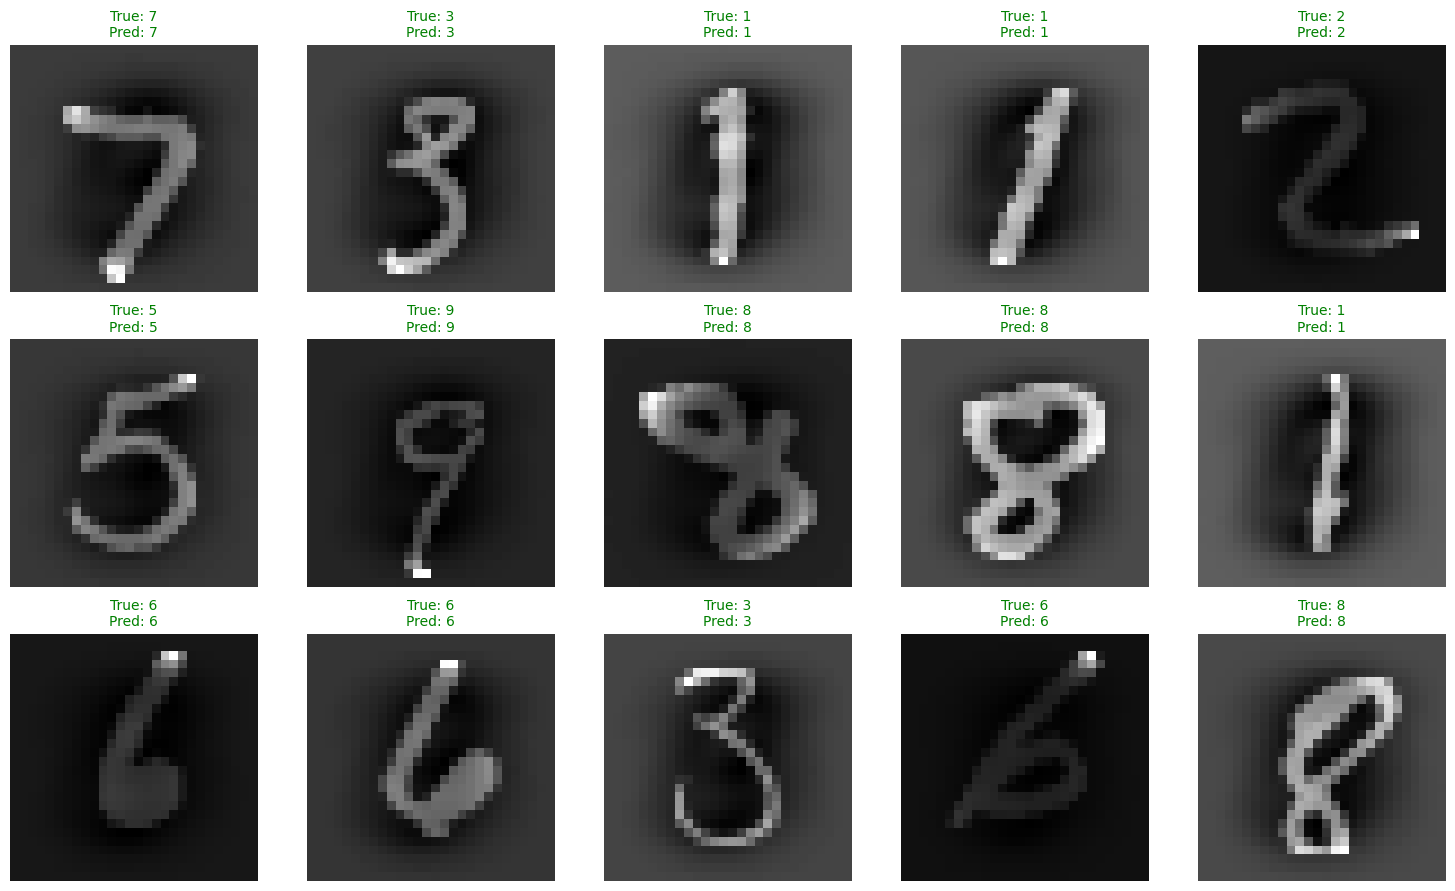

In [18]:
# =======================================
# Show some test images with predictions
# =======================================
# y_pred for the the TASK-IL setting needs to be changed to reflect task-specific heads for the image plotting
# convert the 0 and 1 of y_pred to the corresponding original labels of y_test
# 0 in y_pred to face a 5 in y_test, lead to y_pred_plot = 4
# 1 in y_pred to face a 5 in y_test, lead to y_pred_plot = 5
y_pred_plot = np.zeros_like(y_test)
for t in range(num_tasks):
    digits = list(range(t * 2, (t + 1) * 2))
    # indices of test samples belonging to this task
    task_indices = np.where(np.isin(y_test, digits))[0]

    # build task-specific test set with local labels
    X_task = X_test[task_indices]
    y_task = y_test[task_indices] - digits[0]

    task_dataset = df_to_tensor_dataset(X_task, y_task)
    test_loader = make_dataloaders(task_dataset, batch_size=64, shuffle=False)

    y_pred_task, _, _ = predict_loader(prognet, test_loader, task_id=t, device=device)

    # map predictions back to global label space
    y_pred_plot[task_indices] = y_pred_task
print(y_pred_plot)
plot_mnist_images(
    X=X_test,
    y=y_test,
    y_pred=y_pred_plot,
    num_images=15
)

In [ ]:
# =======================================
# Evaluate model on test set using multi-head inference
# =======================================

try to train on TASK-IL methods, but then to evaluate on CLASS-IL style
--> not great based on confidence, since it can be condifent between 8 and 9 but for a 1 and more than the 1 itself against the 0, so it's clearly not working 
(it could work on datasets where more classes are involded per task, to have better separation and more confidence gap between tasks)

Overall TASK-IL Test Accuracy (no task id): 0.3248
[0 1 2 3 4 5 6 7 8 9]


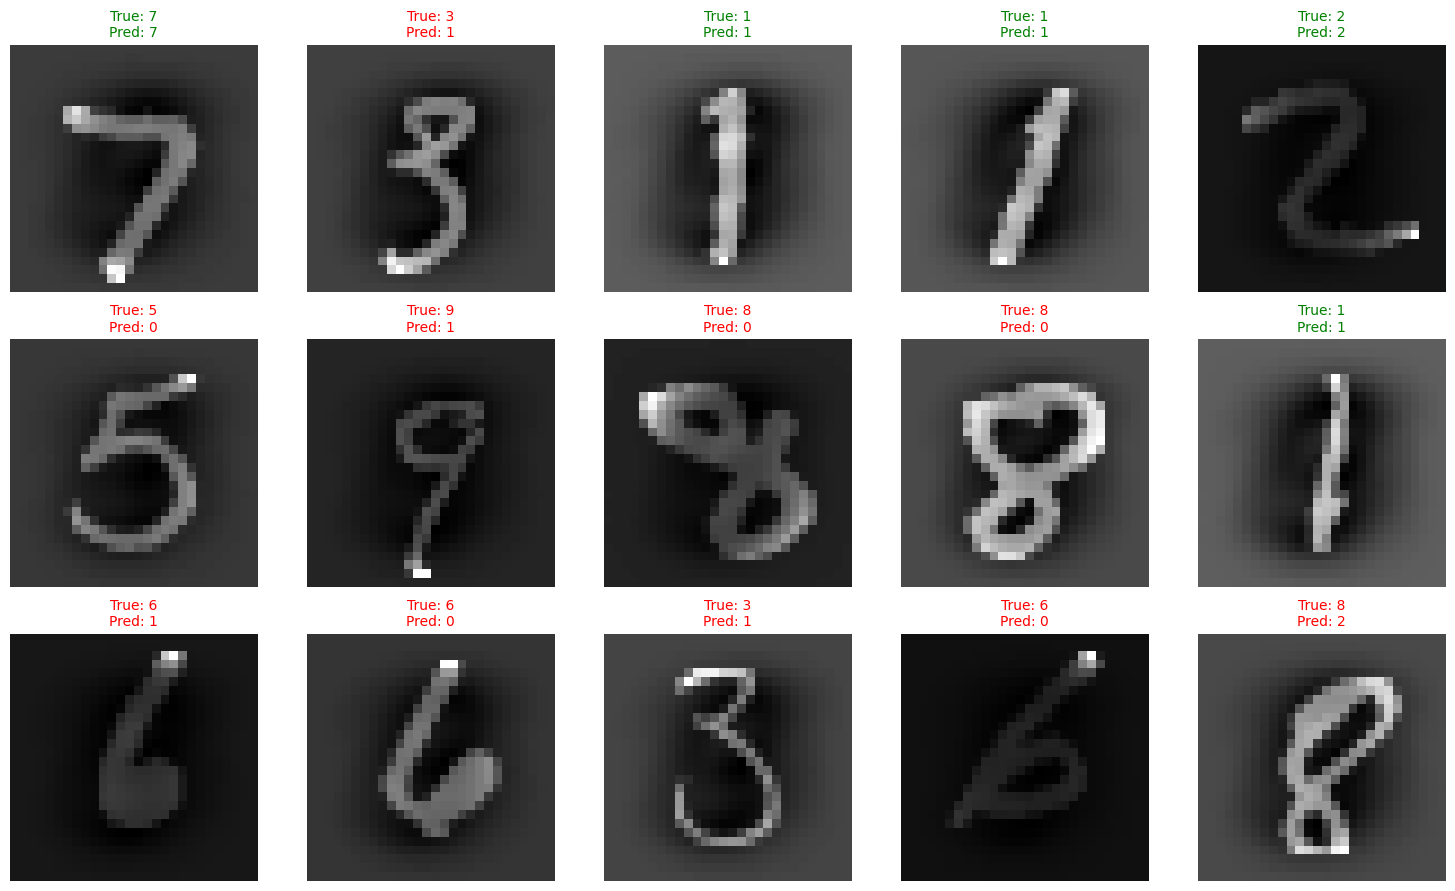

In [ ]:
def predict_loader_multihead(model, loader, num_tasks, digits_per_task, device=None):
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)

            batch_size = X_batch.size(0)
            all_task_conf = []
            all_task_preds = []

            # run all heads
            for t in range(num_tasks):
                logits = model(X_batch, task_id=t)
                probs = torch.softmax(logits, dim=1)
                conf, preds = probs.max(dim=1)

                all_task_conf.append(conf)      # (B,)
                all_task_preds.append(preds)    # (B,)

            # shape: (B, num_tasks)
            conf_stack = torch.stack(all_task_conf, dim=1)
            best_task = conf_stack.argmax(dim=1)

            # final prediction per sample
            final_preds = torch.zeros(batch_size, dtype=torch.long, device=device)

            for i in range(batch_size):
                t = best_task[i]
                final_preds[i] = all_task_preds[t][i]

            all_preds.append(final_preds.cpu())
            all_targets.append(y_batch.cpu())

    return (torch.cat(all_preds).numpy(), torch.cat(all_targets).numpy())

def evaluate_multihead(model, dataset, num_tasks, digits_per_task, device, batch_size=64):
    loader = make_dataloaders(dataset, batch_size=batch_size, shuffle=False)
    y_pred, y_true = predict_loader_multihead(model, loader, num_tasks, digits_per_task, device)
    return np.mean(y_pred == y_true), y_pred, y_true

test_dataset = df_to_tensor_dataset(X_test, y_test)
test_acc, test_preds, test_trues = evaluate_multihead(prognet, test_dataset, num_tasks=num_tasks, digits_per_task=2, device=device)
print(f"Overall TASK-IL Test Accuracy (no task id): {test_acc:.4f}")
plot_mnist_images(
    X=X_test,
    y=y_test,
    y_pred=test_preds,
    num_images=15
)